In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import asymNdimPdf as apdf

In [3]:
cov = np.array([
    [ 1.0000, -0.1949,  0.2583, -0.3933],
    [-0.1949,  1.0000, -0.1188,  0.2919],
    [ 0.2583, -0.1188,  1.0000, -0.3443],
    [-0.3933,  0.2919, -0.3443,  1.0000],
])

measList = np.array([
    [294288603.77097332, 29726222.606283784, -23672504.108643234],
    [1422822752.7824574, 34181144.593426704, -33513316.302916765],
    [1267256904.8604925, 34413027.555306196, -32740743.069167614],
    [189913774.63168541, 17348726.511133254, -19868612.427323759],
])
measList = np.abs(measList) * 1e-6

In [4]:
snParams = []
for m in measList:
    snParams.append(apdf.paramFromMeas(m[0], m[2], m[1]))

In [5]:
# N-dim PDF
loc, scale, alpha = [], [], []
for p in snParams:
    loc.append(p[0])
    scale.append(p[1])
    alpha.append(p[2])

ndSN = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov, alpha=alpha)

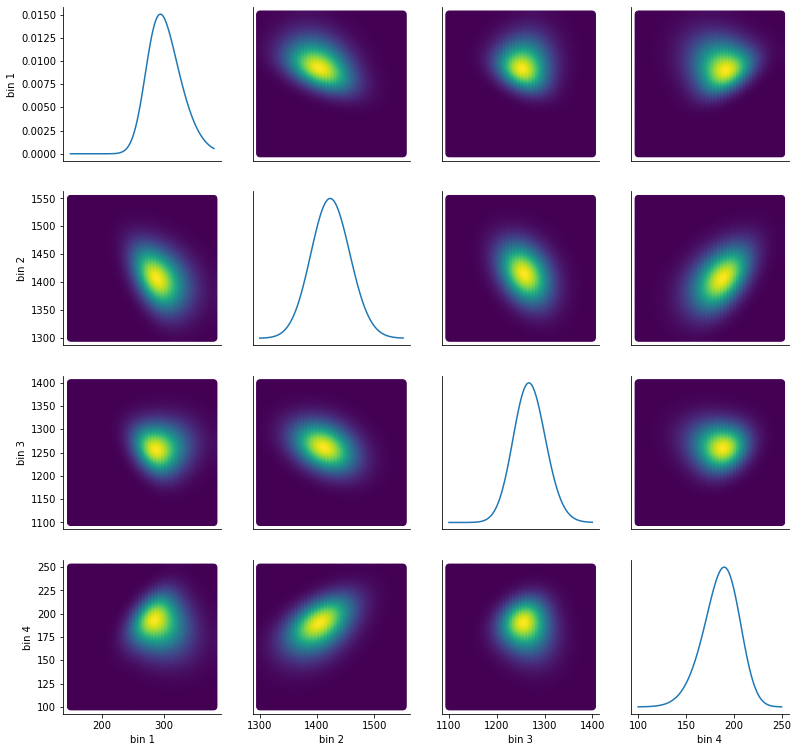

In [8]:
# Random variable ranges
borders = [ 
          [ 150,  380], 
          [1300, 1550],
          [1100, 1400],
          [ 100,  250],
         ]

varName = ['bin 1', 'bin 2', 'bin 3', 'bin 4']

# Plotting each variable pair
ndSN.plot(varNames=varName, borders=borders, nPoints=100, contour=False)

In [15]:
def getToysGaussian(n):
    '''
    Sampling based on gaussians PDFs
    '''
    
    Xs = []
    loc, scale = [], []
    for m in measList:
        loc.append(m[0])
        scale.append(max(m[1], m[2])*2)

    Xs = np.random.normal(loc=loc, scale=scale, size=(n, 4))
    Ys = np.random.rand(n) * np.max(ndSN.pdf(Xs))
    
    return Xs[ndSN.pdf(Xs)>=Ys]

In [16]:
data=getToysGaussian(9000000)
print(data.shape[0] /9000000. * 100 )

4.1163


In [17]:
toys = apdf.generateData(ndSN.pdf, n=9000000, borders=[[150, 400], [1300, 1500], [1100, 1400], [100, 250]])
print(toys.shape[0] /9000000. * 100 )

1.3504666666666667


In [26]:
def getNtoys(pdf, nMin, borders, chunck=100000):
    '''
    Specify the wanted number of toys.
    '''
    nToys, data = 0, []
    while nToys<nMin:
        data.append(apdf.generateData(pdf, n=chunck, borders=borders))
        nToys += data[-1].shape[0]
    return np.concatenate(data)

In [29]:
%timeit getNtoys(ndSN.pdf, nMin=200000, borders=borders, chunck=10000)

6.03 s ± 472 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
def getNtoysGaussian(nMin, chunck=100000):
    '''
    Specify the wanted number of toys.
    '''
    nToys, data = 0, []
    while nToys<nMin:
        data.append(getToysGaussian(chunck))
        nToys += data[-1].shape[0]
    return np.concatenate(data)

In [28]:
%timeit getNtoysGaussian(200000, chunck=10000)

2.72 s ± 378 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
